In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import MeanSquaredError
from keras.losses import MeanAbsolutePercentageError
from keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout
from tensorflow.keras.optimizers import SGD

api_data = yf.download('EBAY', start='2010-01-01', end='2021-12-31', progress=False)

all_data = api_data[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
all_data.head(10)

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2010-01-04,9.58,9.98,10.09,9.94,10.06,22511650
2010-01-05,9.48,10.01,10.06,9.89,9.95,26683193
2010-01-06,9.42,9.95,10.02,9.87,9.89,26368610
2010-01-07,9.31,9.89,9.89,9.75,9.78,25220052
2010-01-08,9.42,9.76,9.95,9.72,9.89,30484080
2010-01-11,9.40,9.90,10.00,9.79,9.87,18331078
2010-01-12,9.29,9.84,9.87,9.66,9.76,25572175
2010-01-13,9.46,9.82,9.95,9.73,9.93,24620587
2010-01-14,9.17,9.89,9.89,9.62,9.63,42094166


In [ ]:
def ts_train_test(all_data,time_steps,for_periods):

    ts_train = all_data[:'2020'].iloc[:,0:1].values
    ts_test  = all_data['2021':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)
 
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train[i-time_steps:i,0])
        y_train.append(ts_train[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2020'], all_data["Adj Close"]['2021':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)

    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test

In [ ]:
X_train, y_train, X_test = ts_train_test(all_data,5,2)
X_train.shape[0],X_train.shape[1]

(2763, 5)

In [ ]:
# Convert the 3-D shape of X_train to a data frame so we can see: 
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see,y_train_see],axis=1)

# Convert the 3-D shape of X_test to a data frame so we can see: 
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1])))
pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 2763 samples in the training data
There are 249 samples in the test data


In [ ]:
X_test_see.head(10)

,0,1,2,3,4
0,49.14,49.26,49.87,49.56,49.27
1,49.26,49.87,49.56,49.27,50.49
2,49.87,49.56,49.27,50.49,51.01
3,49.56,49.27,50.49,51.01,52.18
4,49.27,50.49,51.01,52.18,52.02
5,50.49,51.01,52.18,52.02,53.42
6,51.01,52.18,52.02,53.42,52.88
7,52.18,52.02,53.42,52.88,54.95
8,52.02,53.42,52.88,54.95,54.62
9,53.42,52.88,54.95,54.62,54.19


In [ ]:
def ts_train_test_normalize(all_data,time_steps,for_periods):

    ts_train = all_data[:'2020'].iloc[:,0:1].values
    ts_test  = all_data['2021':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    X_train = []
    y_train = []
    y_train_stacked = []

    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2020'], all_data["Adj Close"]['2021':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    X_test = []

    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

In [ ]:
X_train, y_train, X_test, sc = ts_train_test_normalize(all_data,5,2)

In [ ]:
X_test_see.head(10)

,0,1,2,3,4
0,49.14,49.26,49.87,49.56,49.27
1,49.26,49.87,49.56,49.27,50.49
2,49.87,49.56,49.27,50.49,51.01
3,49.56,49.27,50.49,51.01,52.18
4,49.27,50.49,51.01,52.18,52.02
5,50.49,51.01,52.18,52.02,53.42
6,51.01,52.18,52.02,53.42,52.88
7,52.18,52.02,53.42,52.88,54.95
8,52.02,53.42,52.88,54.95,54.62
9,53.42,52.88,54.95,54.62,54.19


In [ ]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [ ]:
def actual_pred_plot(preds):

    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = all_data.loc['2021':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]
    
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))

    mape = MAPE(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))

    return (m.result().numpy(), mape, actual_pred.plot())

In [ ]:
def simple_rnn_model(X_train, y_train, X_test, sc):

    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2))

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

    my_rnn_model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)

    rnn_predictions = my_rnn_model.predict(X_test)
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    return my_rnn_model, rnn_predictions

(8.007207,
 3.459669580548239,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fde93818610>)

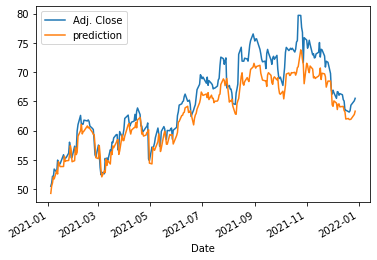

In [ ]:
my_rnn_model, rnn_predictions = simple_rnn_model(X_train, y_train, X_test, sc)
rnn_predictions_2[1:10]
actual_pred_plot(rnn_predictions)

In [ ]:
def LSTM_model(X_train, y_train, X_test, sc):

    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dense(units=2))

    my_LSTM_model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')

    my_LSTM_model.fit(X_train,y_train,epochs=100,batch_size=8, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

(9.830783,
 3.775262148630746,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fde98bb0050>)

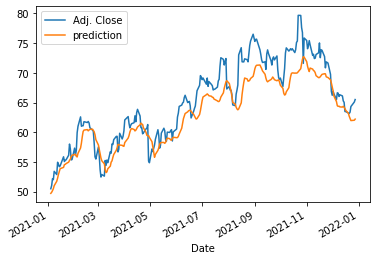

In [ ]:
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)  

In [ ]:
def GRU_model(X_train, y_train, X_test, sc):

    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(GRU(units=50, activation='tanh'))
    my_GRU_model.add(Dense(units=2))

    my_GRU_model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    my_GRU_model.fit(X_train,y_train,epochs=100,batch_size=8, verbose=0)

    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)

    return my_GRU_model, GRU_prediction

(5.0021615,
 2.750559946993416,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fde8d78fd10>)

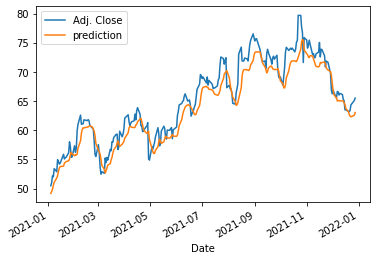

In [ ]:
my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction) 